# Predict ED admission probability

This notebook demonstrates the first stage of prediction, to generate a probability of admission for each patient in the ED. 

As one of the modelling decisions is to send predictions at specified times of day, we tailor the models to these times and train one model for each time. The dataset used for this modelling is derived from snapshots of visits at each time of day. The times of day are define in config.json file in the root directory of this repo. 

A patient episode (visit) may well span more than one of these times, so we need to consider how we will deal with the occurence of multiple snapshots per episode. At each of these times of day, we will use only one training sample from each hospital episode.

Separation of the visits into training, validation and test sets will be done chronologically into a training, validation and test set 

Evaluation of individual level models includes: 
- feature importance plots
- calibration plot
- MADCAP overall, plus breakdown by age category and length of stay


## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'Repos'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))


## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [3]:
# indicate whether the notebook is being run locally for UCLH or with public datasets
uclh = False

In [4]:
if uclh:
    
    model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
    data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
    media_file_path = USER_ROOT / 'ed-predictor' / 'media'
    media_file_path.mkdir(parents=True, exist_ok=True)

else:
    
    model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
    data_path = USER_ROOT / 'patientflow' / 'data-raw'
    media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'

In [5]:
from load import load_config_file

if uclh:
    config_path = Path(USER_ROOT / 'patientflow' / 'config-uclh.yaml')
else:
    config_path = Path(USER_ROOT / 'patientflow' / 'config.yaml')

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]


## Load data

In [6]:
import pandas as pd
from load import set_file_locations
from load import data_from_csv

if uclh:
    data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
    model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
    model_file_path.mkdir(parents=True, exist_ok=True)
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_file_locations(uclh, data_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_file_locations(uclh, data_path)

visits = data_from_csv(visits_csv_path, index_column = 'snapshot_id',
                            sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                            eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date



In [7]:
# print start and end dates
print(visits.snapshot_date.min())
print(visits.snapshot_date.max())

2030-04-01
2032-04-30


See how many visits there are at each time of day in the dataset. We see that number of visits represented is greater in the afternoon and evening

In [8]:
print(visits.prediction_time.value_counts())

prediction_time
(15, 30)    57144
(22, 0)     47115
(12, 0)     46749
(9, 30)     27707
(6, 0)      19383
Name: count, dtype: int64


We will confirm that the dataset aligns with the specified times of day set in the parameters file config.yaml. That is because, later, we will use these times of day to evaluate the predictions. The evaluation will fail if the data loaded does not match. 

In [9]:
print("\nTimes of day at which predictions will be made")
print(prediction_times)
print("\nNumber of rows in dataset that are not in these times of day")
print(len(visits[~visits.prediction_time.isin(prediction_times)]))


Times of day at which predictions will be made
[(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]

Number of rows in dataset that are not in these times of day
0


## Set an index column in visits

Setting the index as the snapshot_id before subsetting means that we retain the same values of snapshot_id throughout the entire process, ensuring that they are consistent across the original dataset visits and the training, validation and test subsets of visits

In [10]:
visits.head()

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2030-04-09,"(12, 0)",1.0,780.0,F,45-54,Walk-in,waiting,2.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,121958,surgical
1,2030-04-09,"(15, 30)",1.0,13380.0,F,45-54,Walk-in,majors,5.0,30.0,...,0.5,141.0,6.84,7.371,5.28,train,[],False,146867,surgical
2,2030-08-03,"(12, 0)",3.0,4620.0,M,65-74,Walk-in,waiting,2.0,377.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,131932,medical
3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,NaN,sdec,4.0,400.0,...,1.2,136.0,5.41,7.371,14.10,train,[acute],True,103694,surgical
4,2030-04-24,"(12, 0)",5.0,4500.0,F,35-44,Walk-in,sdec_waiting,4.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[ambulatory],False,119879,surgical


After executing the code below, the snapshot_id has been set as the index column.

In [11]:
if visits.index.name != 'snapshot_id':
    visits = visits.set_index('snapshot_id')
visits.head()

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2030-04-09,"(12, 0)",1.0,780.0,F,45-54,Walk-in,waiting,2.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,121958,surgical
1,2030-04-09,"(15, 30)",1.0,13380.0,F,45-54,Walk-in,majors,5.0,30.0,...,0.5,141.0,6.84,7.371,5.28,train,[],False,146867,surgical
2,2030-08-03,"(12, 0)",3.0,4620.0,M,65-74,Walk-in,waiting,2.0,377.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,131932,medical
3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,NaN,sdec,4.0,400.0,...,1.2,136.0,5.41,7.371,14.10,train,[acute],True,103694,surgical
4,2030-04-24,"(12, 0)",5.0,4500.0,F,35-44,Walk-in,sdec_waiting,4.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[ambulatory],False,119879,surgical


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. This has been done chronologically, as shown by the output below. Using a chronological approach is appropriate for tasks where the model needs to be validated on unseen, future data.


In [12]:
for value in visits.training_validation_test.unique():
    subset = visits[visits.training_validation_test == value]
    counts = subset.training_validation_test.value_counts().values[0]
    min_date = subset.snapshot_date.min()
    max_date = subset.snapshot_date.max()
    print(f"Set: {value}\nNumber of rows: {counts}\nMin Date: {min_date}\nMax Date: {max_date}\n")

Set: train
Number of rows: 142335
Min Date: 2030-04-01
Max Date: 2031-08-31

Set: test
Number of rows: 44497
Min Date: 2031-11-01
Max Date: 2032-04-30

Set: valid
Number of rows: 11266
Min Date: 2031-09-01
Max Date: 2031-10-31



In [14]:
train_visits = visits[visits.training_validation_test == 'train'].drop(columns='training_validation_test')
valid_visits = visits[visits.training_validation_test == 'valid'].drop(columns='training_validation_test')
test_visits = visits[visits.training_validation_test == 'test'].drop(columns='training_validation_test')

assert train_visits.snapshot_date.min() == start_training_set
assert train_visits.snapshot_date.max() < start_validation_set
assert valid_visits.snapshot_date.min() == start_validation_set
assert valid_visits.snapshot_date.max() < start_test_set
assert test_visits.snapshot_date.min() == start_test_set
assert test_visits.snapshot_date.max() < end_test_set

We can see below that some visits appear more than once in each of these sets. (No visit appears in more than one set.)

In [15]:
train_visits.visit_number.value_counts()

visit_number
17425.0     15
107960.0    14
60764.0     14
56211.0     13
49148.0     13
            ..
46385.0      1
46384.0      1
46383.0      1
46381.0      1
196144.0     1
Name: count, Length: 114775, dtype: int64

For example, the below patient has 16 episode slices. It's quite possible that this patient has already left the ED but the discharge has not been updated on the patient record. While it is tempting to remove these later, in real-time these patients would be picked up, so a model would ideally be trained on this data also. Therefore we do need to include them in our training set. 

In [28]:
train_visits[train_visits.visit_number == 17425.0].sort_values(['snapshot_date', 'prediction_time'])

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_k,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
18826,2030-06-06,"(22, 0)",17425.0,2071.0,M,75-102,Ambulance,rat,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,[acute],False,193358,NaN
18827,2030-06-07,"(6, 0)",17425.0,30871.0,M,75-102,Ambulance,majors,4.0,52.0,...,4.7,NaN,138.0,NaN,NaN,3.7,[acute],False,86437,NaN
18828,2030-06-07,"(9, 30)",17425.0,43471.0,M,75-102,Ambulance,otf,5.0,71.0,...,4.7,NaN,138.0,NaN,NaN,3.7,[acute],False,147349,NaN
18829,2030-06-07,"(12, 0)",17425.0,52471.0,M,75-102,Ambulance,otf,5.0,71.0,...,4.7,NaN,138.0,NaN,NaN,3.7,[acute],False,132715,NaN
18830,2030-06-07,"(15, 30)",17425.0,65071.0,M,75-102,Ambulance,otf,5.0,71.0,...,4.7,NaN,138.0,NaN,NaN,3.7,[acute],False,115900,NaN
18831,2030-06-07,"(22, 0)",17425.0,88471.0,M,75-102,Ambulance,otf,5.0,71.0,...,4.7,NaN,138.0,NaN,NaN,3.7,[acute],False,23729,NaN
18832,2030-06-08,"(6, 0)",17425.0,117271.0,M,75-102,Ambulance,otf,5.0,71.0,...,4.7,NaN,138.0,NaN,NaN,3.7,[acute],False,21818,NaN
18833,2030-06-08,"(9, 30)",17425.0,129871.0,M,75-102,Ambulance,otf,5.0,71.0,...,4.7,NaN,138.0,NaN,NaN,3.7,[acute],False,65555,NaN
18834,2030-06-08,"(12, 0)",17425.0,138871.0,M,75-102,Ambulance,otf,5.0,71.0,...,4.7,NaN,138.0,NaN,NaN,3.7,[acute],False,98979,NaN


## Train a XGBoost Classifier for each time of day, and save the best model

### About the approach to model training

The first step is to load a transformer for the ML training data to turn it into a format that our ML classifier can read. This is done using a function called create_column_transformer() which called ColumnTransfomer() a standard method in scikit-learn. This function could be changed for different input

The ColumnTransformer in scikit-learn is a tool that applies different transformations or preprocessing steps to different columns of a dataset in a single operation. OneHotEncoder converts categorical data into a format that can be provided to machine learning algorithms; without this, the model might interpret the categorical data as numerical, which would lead to incorrect results. With the OrdinalEncoder, categories are converted into ordered numerical values to reflect the inherent order in the age groups

We can also specify a grid of hyperparameters, so that the classifier will iterate though them to find the best fitting model. 

We are interested in predictions at different times of day. So we will train a model for each time of day. We will filter each visit so that it only appears once in the training data. A random number has already been included in the dataset to facilitate this.

We then iterate through the grid to find the best model for each time of day, keeping track of the best model and its results. 

The ML models will be trained across a range of different hyperparameter options. When evaluating the best model, we will save common ML metrics (AUC and logloss) and compare each model for the best (lowest) logloss. Apply a chronological approach to the cross-validation split is appropriate for tasks where the model needs to be validated on unseen, future data.

The best model is saved, plus a dictionary of its metadata, including

* how many visits were in training, validation and test sets
* Area under ROC curve and log loss (performance metrics) for training (based on 5-fold cross validation), validation and test sets
* List of features and their importances in the model


The following cell shows some of the Python code used. The same result can be achieved by calling a function called train_models(). Calling this is shown afterwards with a minimal dataset

In [43]:


from sklearn.model_selection import ParameterGrid, cross_validate
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    log_loss,
    roc_auc_score,
)
from joblib import dump

from load import get_model_name
from prepare import get_snapshots_at_prediction_time, get_snapshots_at_prediction_time
from train import chronological_cross_validation, create_column_transformer, initialise_xgb

# initialize a dict to save information about the best models for each time of day
best_model_results_dict = {}

# Option to iterate through different hyperparameters for XGBoost
grid = {
    'n_estimators':[30], #, 40, 50],
    'subsample':[0.7], #, 0.8,0.9],
    'colsample_bytree': [0.7]#, 0.8, 0.9]
}

# certain columns are not used in training
exclude_from_training_data = [
    "visit_number",
    "snapshot_date",
    "prediction_time",
    "specialty",
    "consultation_sequence",
     "final_sequence"]


ordinal_mappings = {
    "age_group": ["0-17", "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-102"],
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_manch_triage": ["Blue", "Green", "Yellow", "Orange", "Red"],
    "latest_pain_objective": ["Nil", "Mild", "Moderate", "Severe\E\Very Severe"]
}


# Process each time of day
for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))

    # create a name for the model based on the time of day it is trained for
    MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', _prediction_time)

    # use this name in the path for saving best model
    full_path = model_file_path / MODEL__ED_ADMISSIONS__NAME 
    full_path = full_path.with_suffix('.joblib')

    # initialise data used for saving attributes of the model
    best_model_results_dict[MODEL__ED_ADMISSIONS__NAME] = {}
    best_valid_logloss = float('inf')
    results_dict = {}
    
    # get visits that were in at the time of day in question and preprocess the training, validation and test sets 
    X_train, y_train = get_snapshots_at_prediction_time(train_visits, _prediction_time, exclude_from_training_data)
    X_valid, y_valid = get_snapshots_at_prediction_time(valid_visits, _prediction_time, exclude_from_training_data)
    X_test, y_test = get_snapshots_at_prediction_time(test_visits, _prediction_time, exclude_from_training_data)
    
    # save size of each set
    best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['train_valid_test_set_no'] = {
        'train_set_no' : len(X_train),
        'valid_set_no' : len(X_valid),
        'test_set_no' : len(X_test),
    }

    # iterate through the grid of hyperparameters
    for g in ParameterGrid(grid):
        model = initialise_xgb(g)
        
        # define a column transformer for the ordinal and categorical variables
        column_transformer = create_column_transformer(X_test, ordinal_mappings)
        
        # create a pipeline with the feature transformer and the model
        pipeline = Pipeline([
            ('feature_transformer', column_transformer),
            ('classifier', model)
        ])

        # cross-validate on training set using the function created earlier
        cv_results = chronological_cross_validation(pipeline, X_train, y_train, n_splits=5)

        # Store results for this set of parameters in the results dictionary
        results_dict[str(g)] = {
            'train_auc': cv_results['train_auc'],
            'valid_auc': cv_results['valid_auc'],
            'train_logloss': cv_results['train_logloss'],
            'valid_logloss': cv_results['valid_logloss'],
        }
        
        # Update and save best model if current model is better on validation set
        if cv_results['valid_logloss'] < best_valid_logloss:

            # save the details of the best model
            best_model = str(g)
            best_valid_logloss = cv_results['valid_logloss']

            # save the best model params
            best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['best_params'] = str(g)

            # save the model metrics on training and validation set
            best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['train_valid_set_results'] = results_dict

            # score the model's performance on the test set  
            y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]
            test_auc = roc_auc_score(y_test, y_test_pred_proba)
            test_logloss = log_loss(y_test,y_test_pred_proba)
        
            best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['test_set_results'] = {
                'test_auc' : test_auc,
                'test_logloss' : test_logloss
            }

            # save the best features
            # To access transformed feature names:
            transformed_cols = pipeline.named_steps['feature_transformer'].get_feature_names_out()
            transformed_cols = [col.split('__')[-1] for col in transformed_cols]
            best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['best_model_features'] = {
                    'feature_names': transformed_cols,
                    'feature_importances': pipeline.named_steps['classifier'].feature_importances_.tolist()
                }

            # save the best model
            dump(pipeline, full_path)

# save the results dictionary      
filename_results_dict = 'best_model_results_dict.json'
full_path_results_dict = model_file_path / filename_results_dict

with open(full_path_results_dict, 'w') as f:
    json.dump(best_model_results_dict, f)  

<>:42: SyntaxWarning: invalid escape sequence '\E'
<>:42: SyntaxWarning: invalid escape sequence '\E'
/var/folders/lr/pm79dxzs0v70y4gz98dl13440000gn/T/ipykernel_91746/328779744.py:42: SyntaxWarning: invalid escape sequence '\E'
  "latest_pain_objective": ["Nil", "Mild", "Moderate", "Severe\E\Very Severe"]



Processing :(6, 0)

Processing :(9, 30)

Processing :(12, 0)

Processing :(15, 30)

Processing :(22, 0)


In [33]:
model_file_path

PosixPath('/Users/zellaking/Repos/patientflow/trained-models')

In [34]:
# see performance of best model
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.795; log loss 0.41
Model: ed_admission_0930; AUC: 0.811; log loss 0.323
Model: ed_admission_1200; AUC: 0.823; log loss 0.294
Model: ed_admission_1530; AUC: 0.822; log loss 0.328
Model: ed_admission_2200; AUC: 0.832; log loss 0.364


## Train using a minimal dataset 

In [40]:
from train import train_models

grid = {
    'n_estimators':[30],
}

# certain columns are not used in training
exclude_from_training_data = [col for col in visits.columns if col not in ['elapsed_los', 'sex', 'age_group', 'arrival_method', 'training_validation_test', 'is_admitted', 'random_number']]


ordinal_mappings = {
}

model_name = 'ed_admissions_minimal'

train_models(visits, 
                grid, 
                exclude_from_training_data,
                ordinal_mappings,
                prediction_times,
                model_name,
                model_file_path,
                'best_minimal_model_results_dict.json')


Processing :(6, 0)

Processing :(9, 30)

Processing :(12, 0)

Processing :(15, 30)

Processing :(22, 0)


In [39]:

full_path_results_dict = model_file_path / 'best_minimum_model_results_dict.json'

with open(full_path_results_dict, 'r') as f:
    best_model_results_dict = json.load(f)

# see performance of best model
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admissions_minimal_0600; AUC: 0.696; log loss 0.456
Model: ed_admissions_minimal_0930; AUC: 0.722; log loss 0.361
Model: ed_admissions_minimal_1200; AUC: 0.71; log loss 0.341
Model: ed_admissions_minimal_1530; AUC: 0.714; log loss 0.38
Model: ed_admissions_minimal_2200; AUC: 0.748; log loss 0.416


### View the model

In [41]:
from prepare import prepare_for_inference
X_test, y_test, model = prepare_for_inference(model_file_path = model_file_path, \
    model_name = 'ed_admissions_minimal', \
    prediction_time = prediction_times[0], \
    data_path = visits_csv_path, \
    single_snapshot_per_visit = False, 
    model_only = False)

In [42]:
# model 
model

Pipeline(steps=[('feature_transformer',
                 ColumnTransformer(transformers=[('elapsed_los',
                                                  StandardScaler(),
                                                  ['elapsed_los']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex']),
                                                 ('age_group',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['age_group']),
                                                 ('arrival_method',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['arrival_method'])])),
                ('classifier',
                 XGBClassifier(...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=30, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

### Plot feature importances and shap plots for each of the five models

The following cells show Shap plots and feature importance plots for each of the five prediction times.

- **Feature Importance Plot**
A feature importance plot is a visual representation that shows the significance of each feature (or variable) in a machine learning model. It helps to understand which features contribute most to the model's predictions. The importance of a feature is typically determined by how much it improves the model's performance. The plot tells you which inputs, in overall terms, have the most influence on the output of the model. This plot is particularly useful for model interpretation, and gaining insights into the underlying data.

- **SHAP Plot**
A SHAP (SHapley Additive exPlanations) plot provides a detailed view of the impact each feature has on the prediction of a machine learning model on a particular dataset, which in the case is the test set. Unlike the feature importance plot, SHAP values explain the contribution of each feature for each individual observation in the test set (with each observation being represented as a dot in the plot). SHAP plots combine game theory and local explanations to show how much each feature increases or decreases the prediction. This helps to interpret not only the overall model behavior but also the specific decisions for individual instances, offering a more granular and transparent view of model predictions.

#### Shap plot - main model

[11:01:17] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


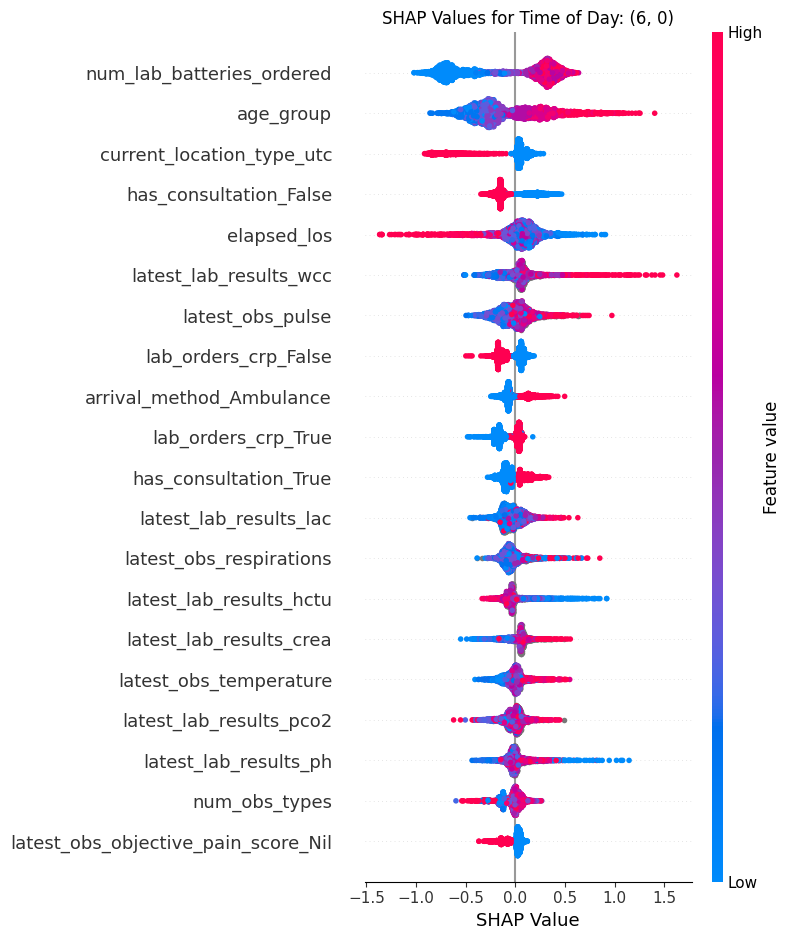

[11:01:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


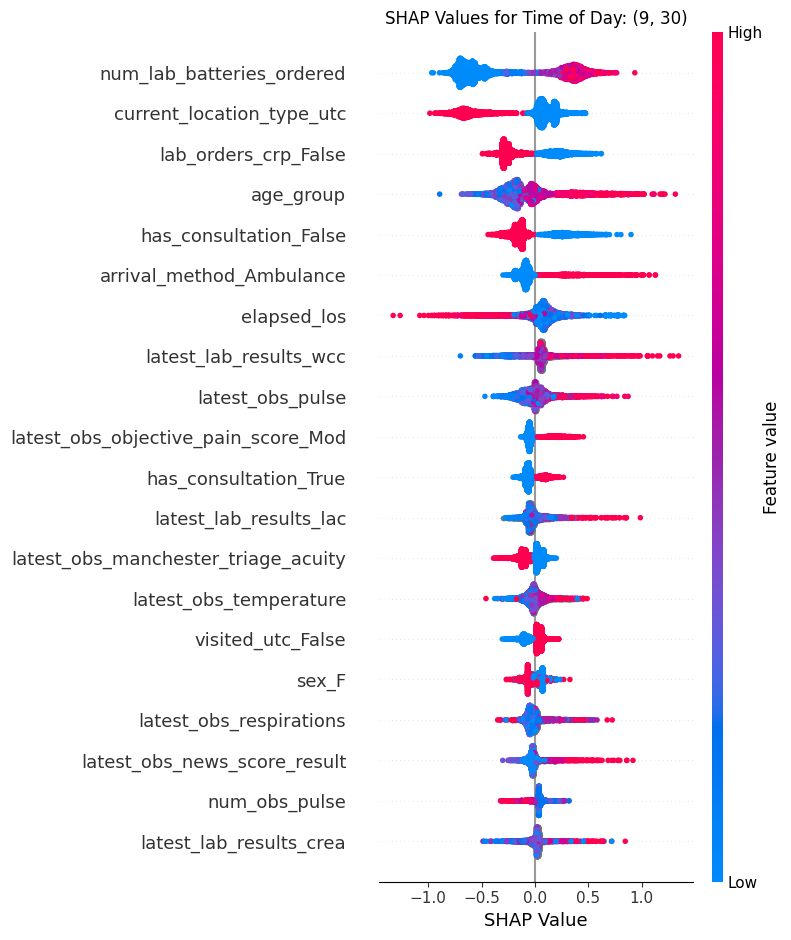

[11:01:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


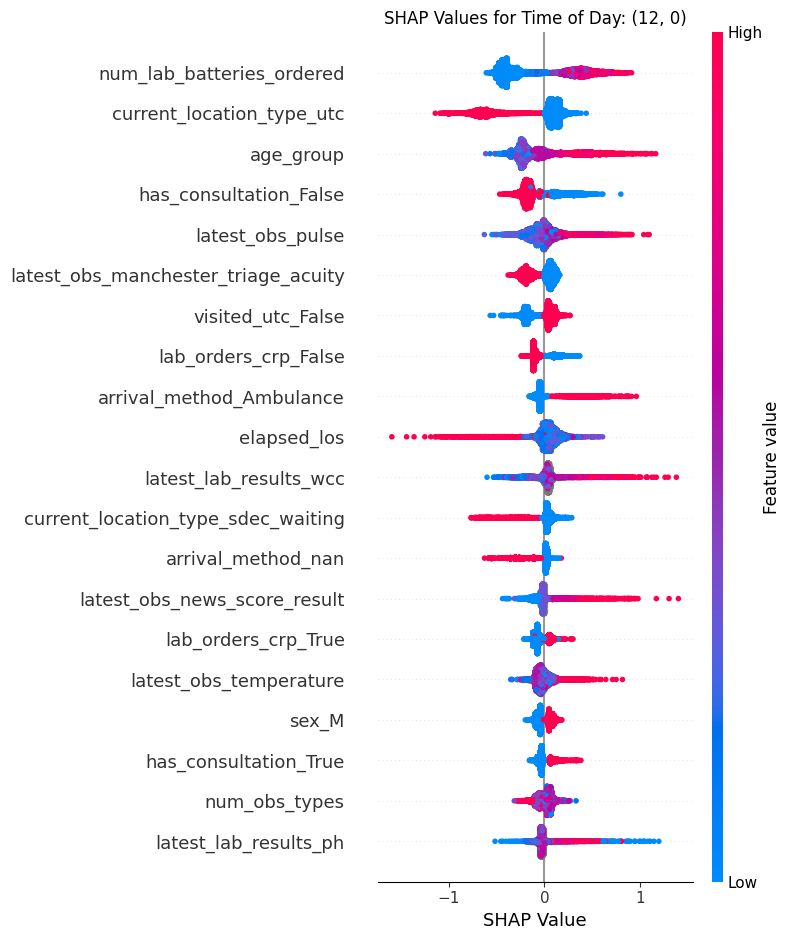

[11:01:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


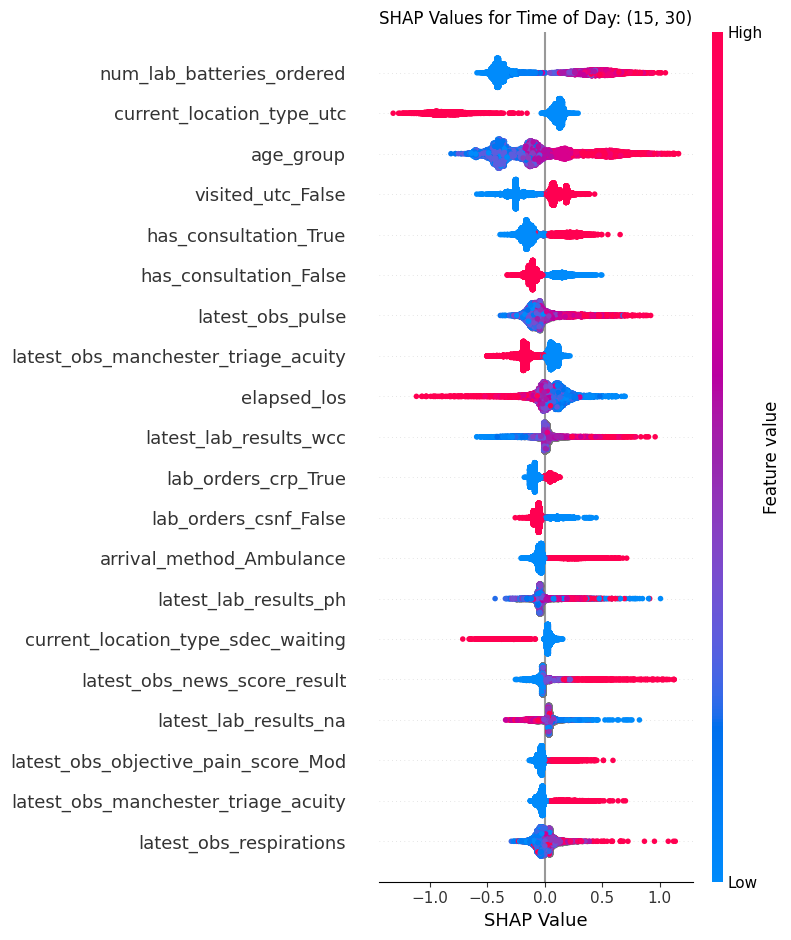

[11:01:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


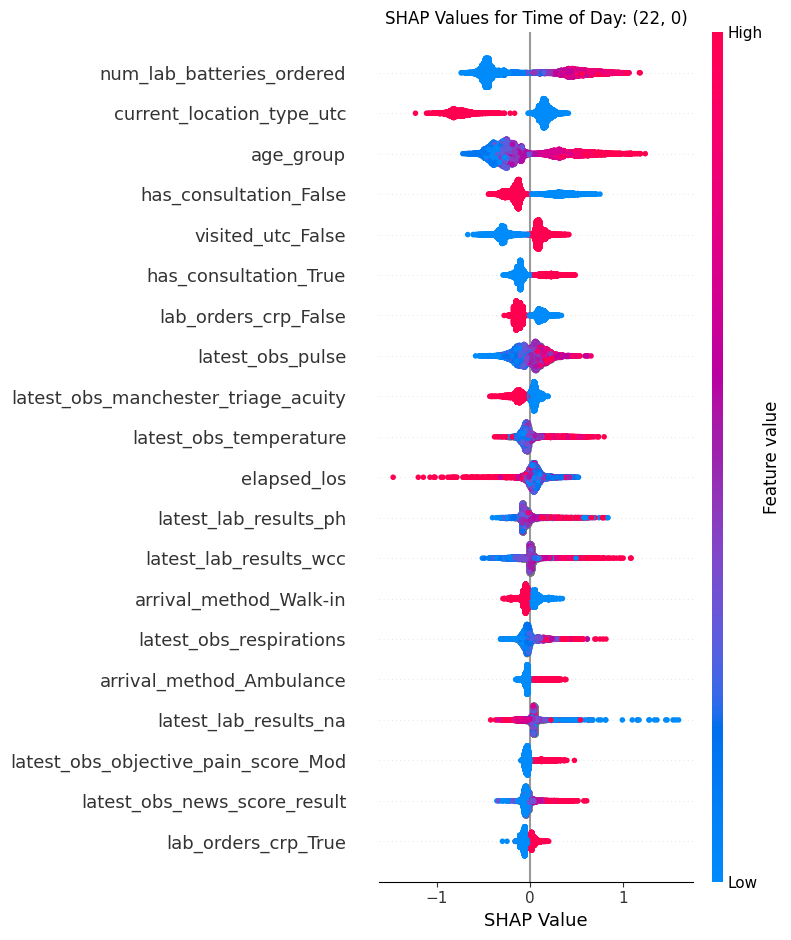

In [28]:
from matplotlib import pyplot as plt
from load import get_model_name
from prepare import prepare_for_inference

import shap
import scipy.sparse


def plot_shap_individually(prediction_times, model_name = 'ed_admission'):
    for i, _prediction_time in enumerate(prediction_times):
        fig, ax = plt.subplots(figsize=(8, 12))
        X_test, y_test, pipeline = prepare_for_inference(model_file_path = model_file_path, model_name = model_name, prediction_time = _prediction_time, data_path = visits_csv_path, single_snapshot_per_visit = False, model_only = False)
        transformed_cols = pipeline.named_steps['feature_transformer'].get_feature_names_out()
        transformed_cols = [col.split('__')[-1] for col in transformed_cols]
        truncated_cols = [col[:35] for col in transformed_cols]


        explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
        X_test = pipeline.named_steps['feature_transformer'].transform(X_test)

        # Convert sparse matrix to dense if necessary
        if scipy.sparse.issparse(X_test):
            X_test = X_test.toarray()

        shap_values = explainer.shap_values(X_test)
        
        shap.summary_plot(shap_values, X_test, feature_names=truncated_cols, 
                        #   color=primary_color, 
                          show=False)
        
        ax.set_title(f'SHAP Values for Time of Day: {_prediction_time}')
        ax.set_xlabel('SHAP Value')
        plt.tight_layout()

        MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', _prediction_time)
        shap_plot_path = str(media_file_path / 'shap_plot_') + MODEL__ED_ADMISSIONS__NAME +'.png'
    
        plt.savefig(shap_plot_path)
        plt.show()
    
plot_shap_individually(prediction_times)

#### Shap plot - minimal model

In [24]:
# X_test, y_test, pipeline = prepare_for_inference(model_file_path = model_file_path, model_name = 'ed_admissions_minimal', prediction_time = (6,0), data_path = visits_csv_path, single_snapshot_per_visit = False, model_only = False)
# transformed_cols = pipeline.named_steps['feature_transformer'].get_feature_names_out()
# transformed_cols = [col.split('__')[-1] for col in transformed_cols]
# truncated_cols = [col[:35] for col in transformed_cols]

explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
X_test_transformed = pipeline.named_steps['feature_transformer'].transform(X_test)
# shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test, feature_names=truncated_cols, 
#                 #   color=primary_color, 
#                     show=False)

[10:58:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [25]:
X_test_transformed

<4210x21 sparse matrix of type '<class 'numpy.float64'>'
	with 16840 stored elements in Compressed Sparse Row format>

[11:00:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


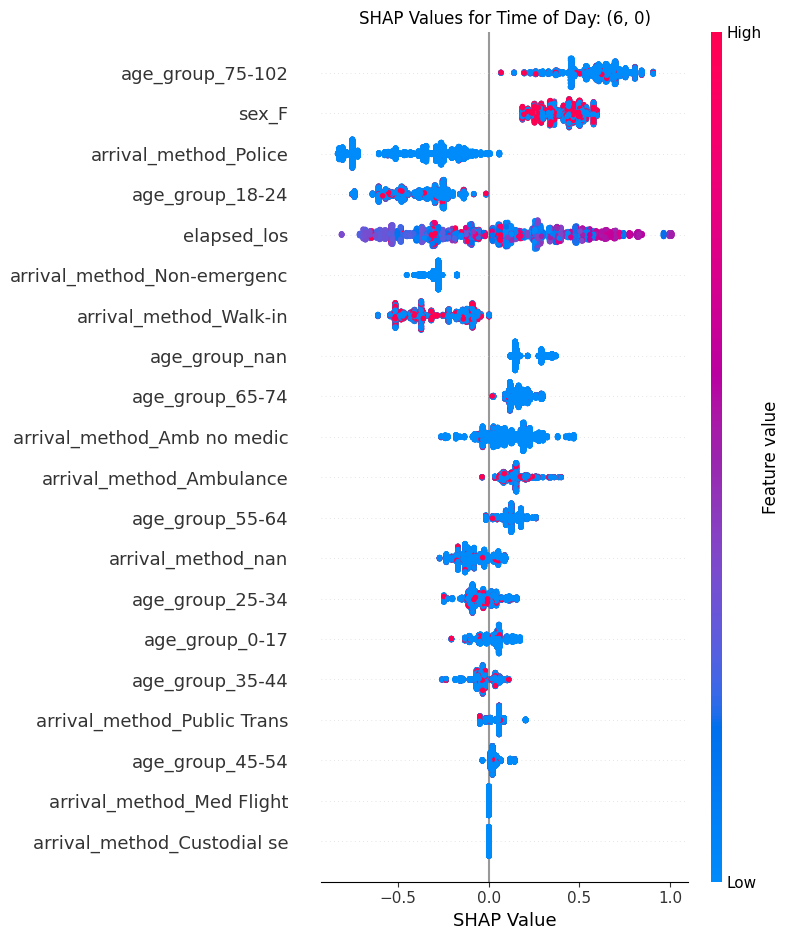

[11:00:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


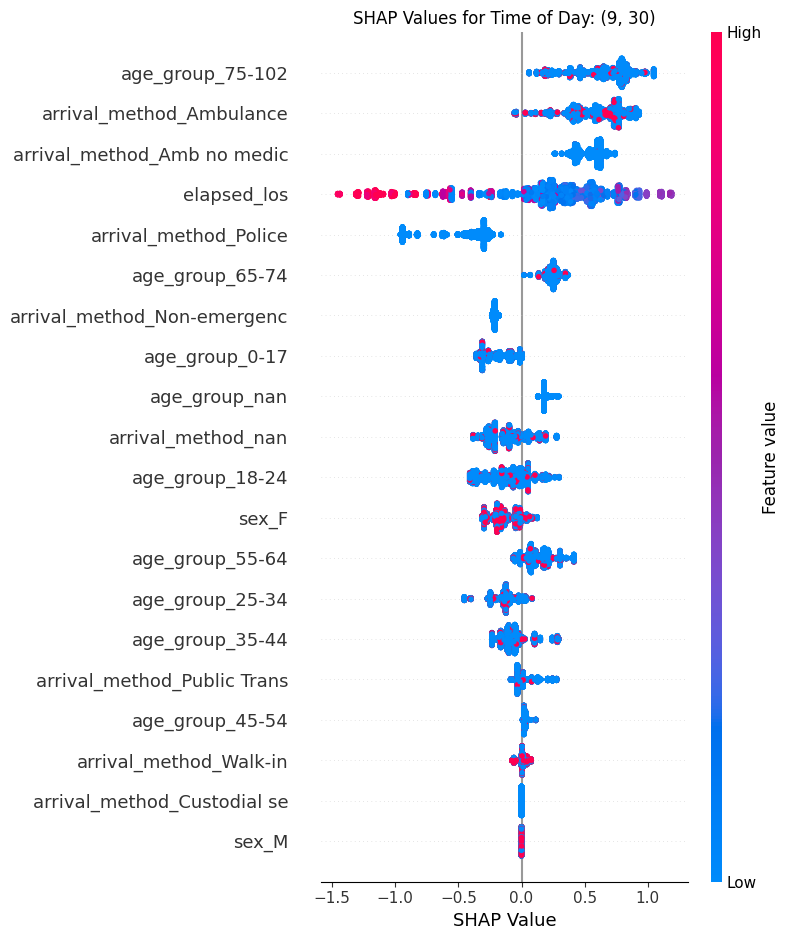

[11:00:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


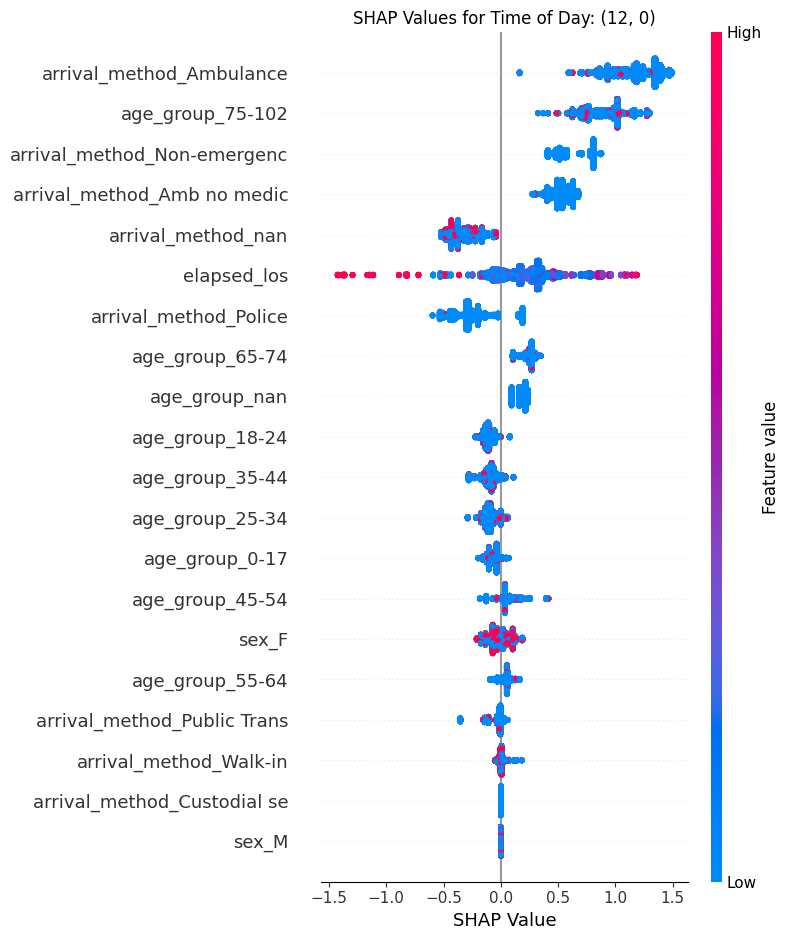

[11:00:38] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


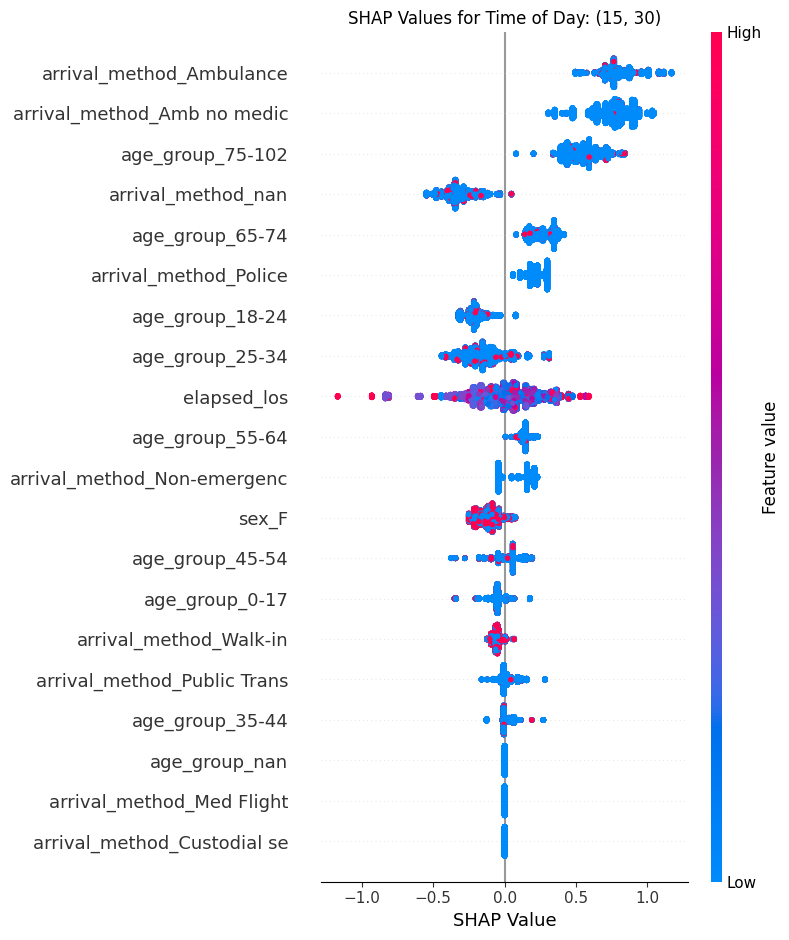

[11:00:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


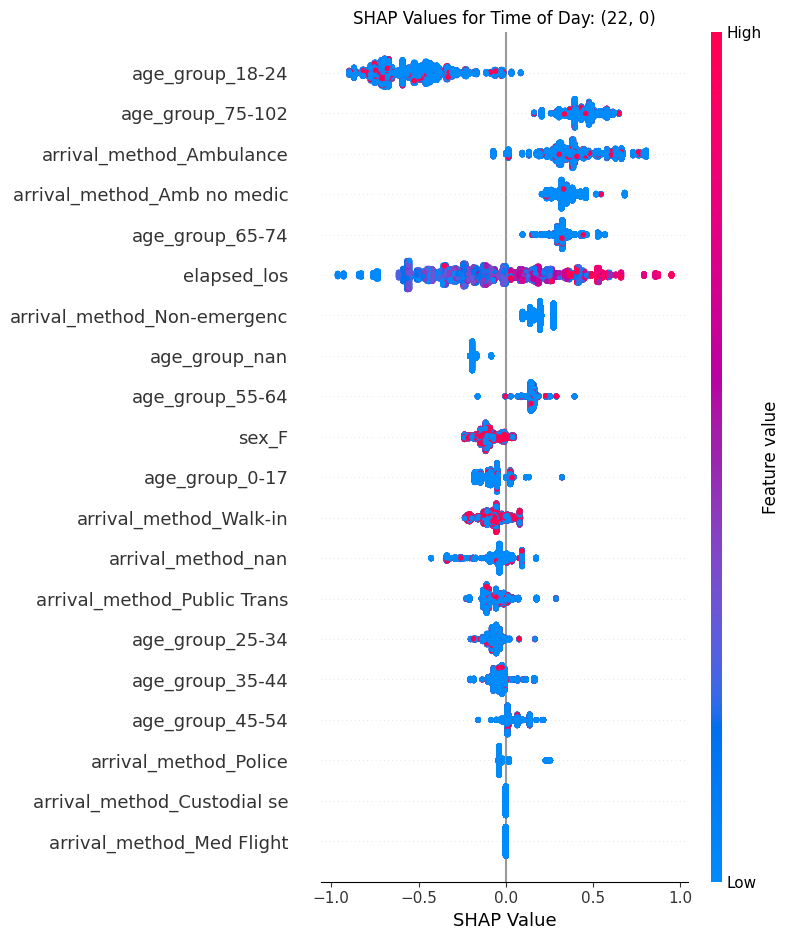

In [27]:

plot_shap_individually(prediction_times, model_name = 'ed_admissions_minimal')  


### Feature plots

#### Feature plot - main model

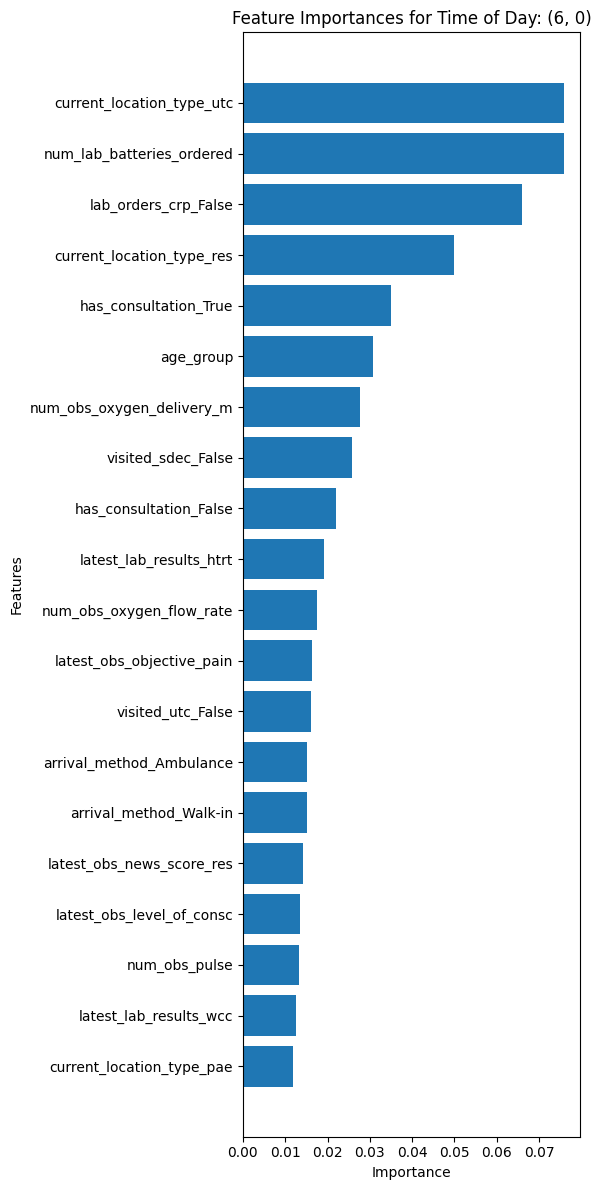

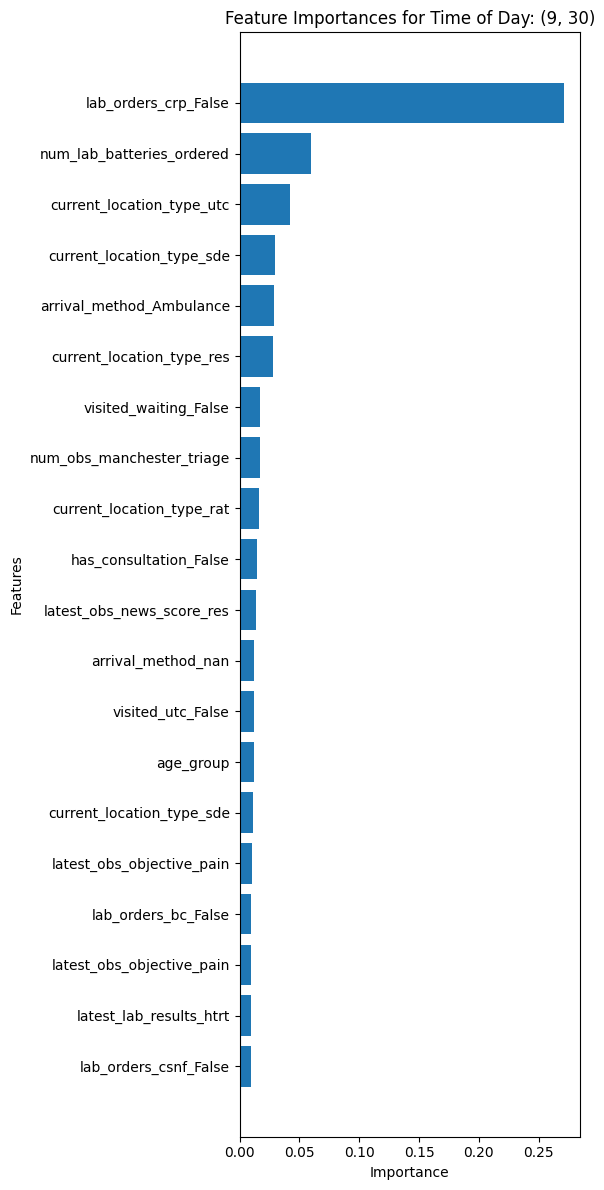

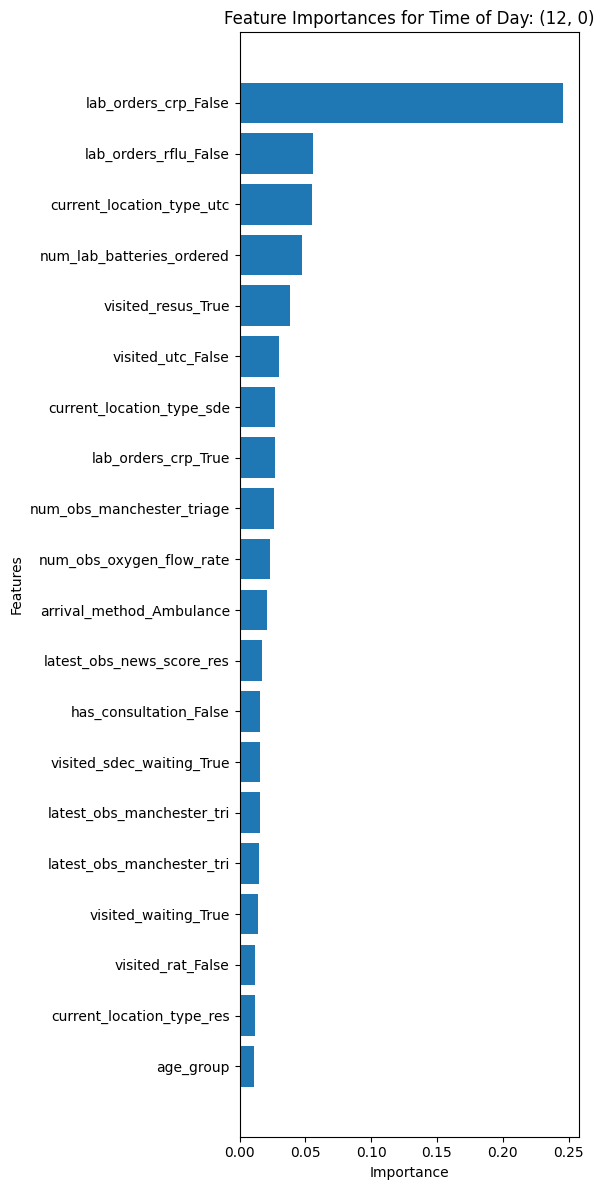

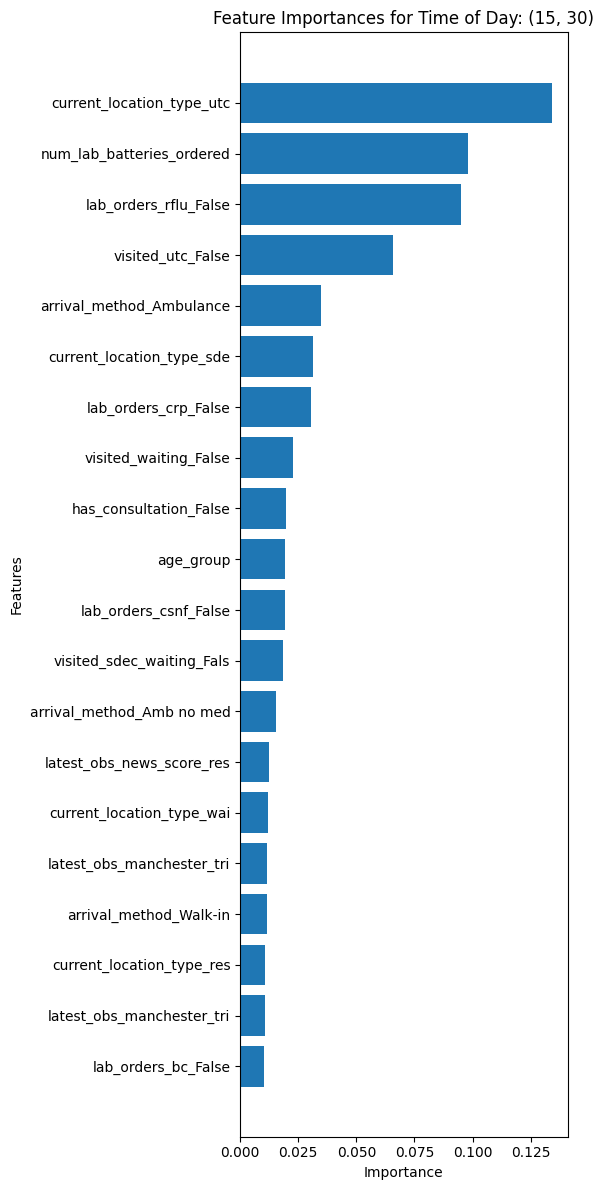

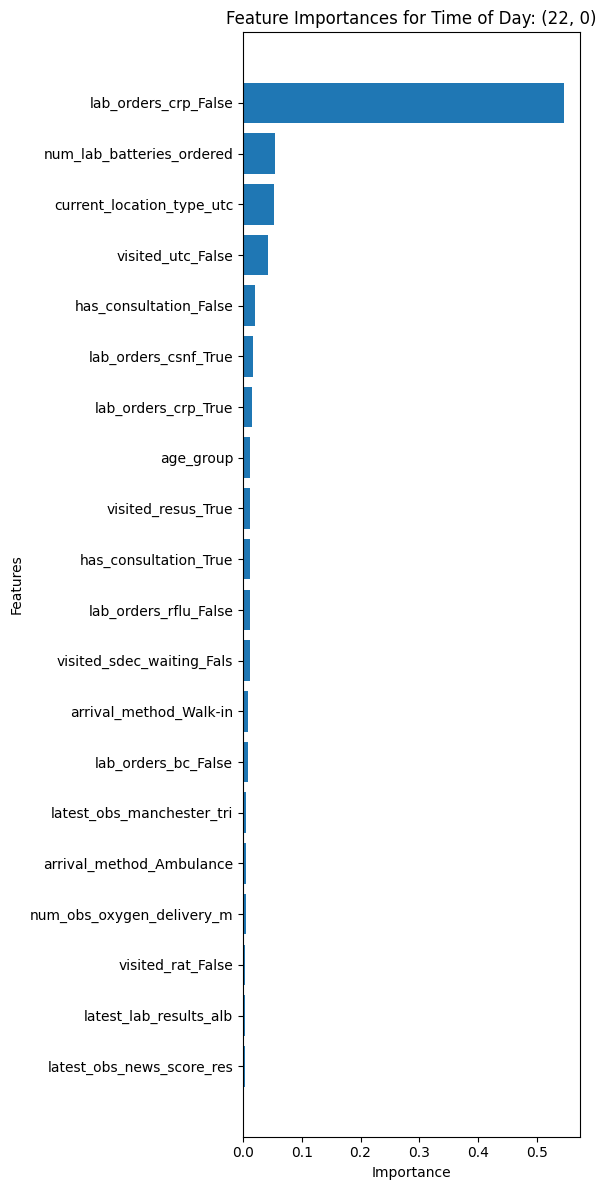

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importances_individually(prediction_times):
    for _prediction_time in prediction_times:
        pipeline = prepare_for_inference(
            model_file_path=model_file_path, 
            model_name='ed_admission', 
            prediction_time=_prediction_time, 
            data_path=visits_csv_path, 
            single_snapshot_per_visit=False, 
            model_only=True
        )
        
        transformed_cols = pipeline.named_steps['feature_transformer'].get_feature_names_out()
        transformed_cols = [col.split('__')[-1] for col in transformed_cols]
        truncated_cols = [col[:25] for col in transformed_cols]
        
        feature_importances = pipeline.named_steps['classifier'].feature_importances_
        indices = np.argsort(feature_importances)[-20:]  # Get indices of the top 20 features
        
        plt.figure(figsize=(6, 12))
        plt.title(f"Feature Importances for Time of Day: {_prediction_time}")
        plt.barh(range(len(indices)), feature_importances[indices], align="center", color=primary_color)
        plt.yticks(range(len(indices)), np.array(truncated_cols)[indices])
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.tight_layout()

        MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', _prediction_time)
        feature_plot_path = str(media_file_path / 'feature_plot_') + MODEL__ED_ADMISSIONS__NAME +'.png'
    
        plt.savefig(feature_plot_path)
        plt.show()

plot_feature_importances_individually(prediction_times)

#### Feature plot - minimal model

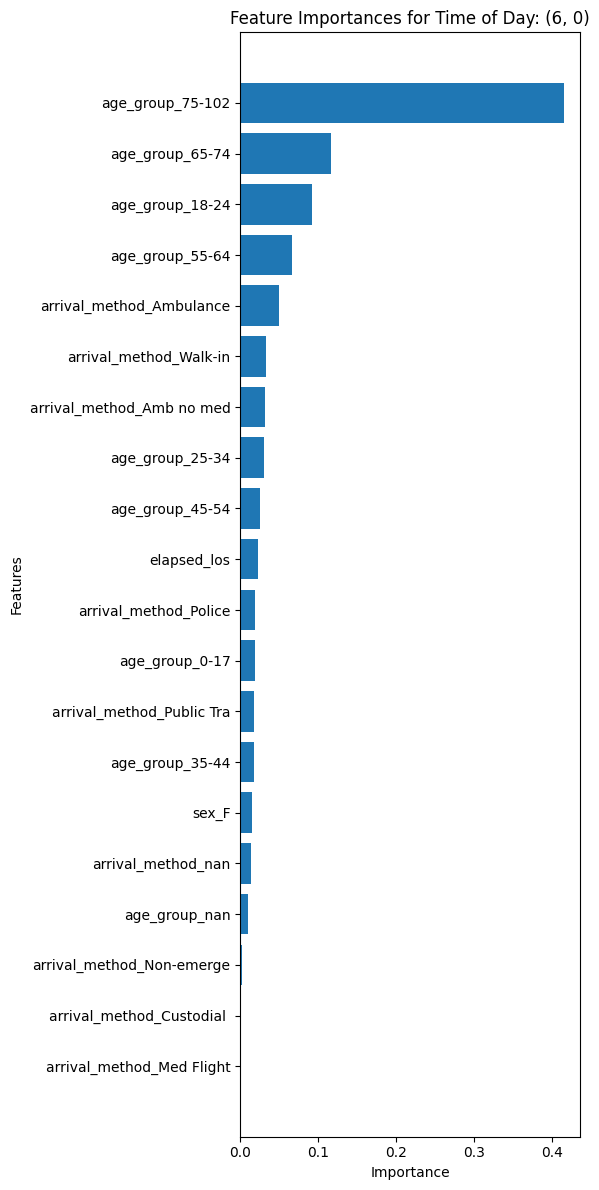

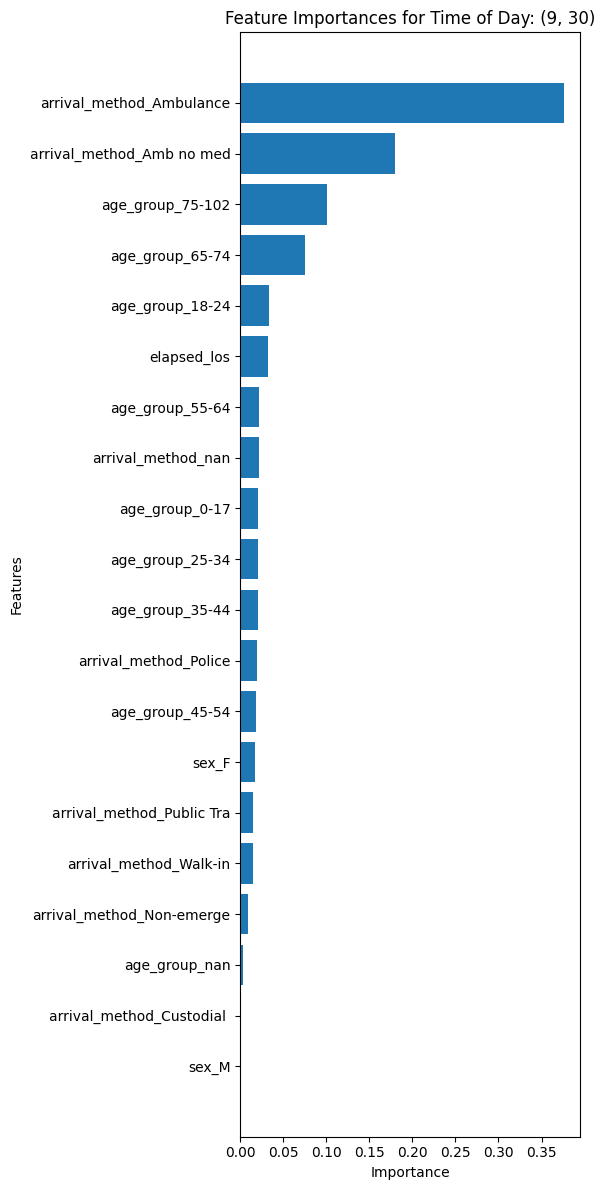

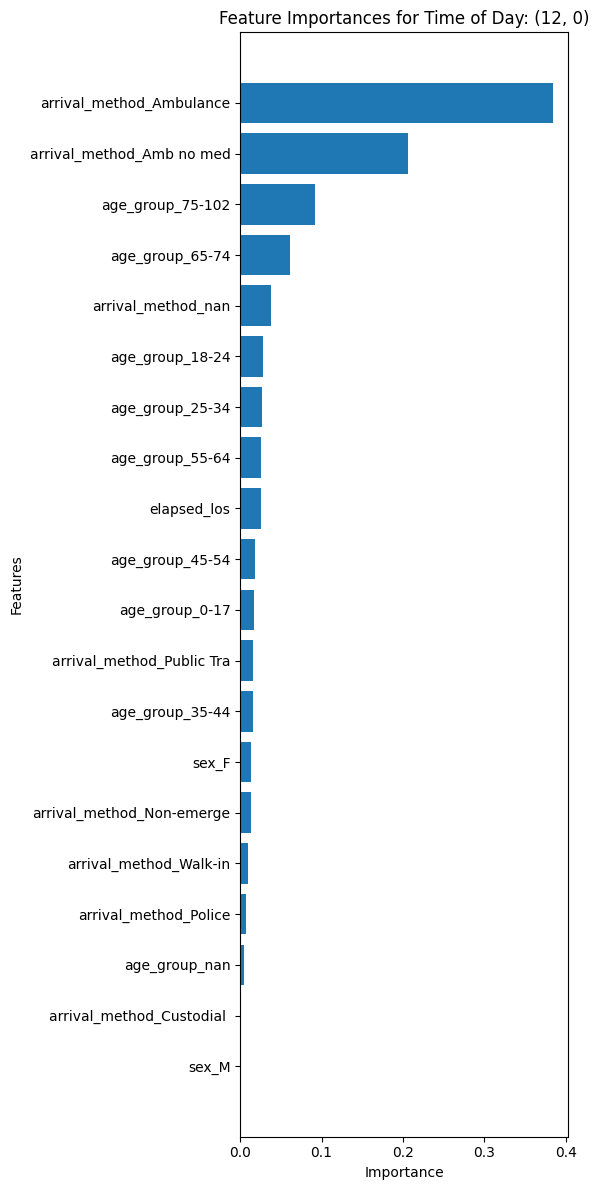

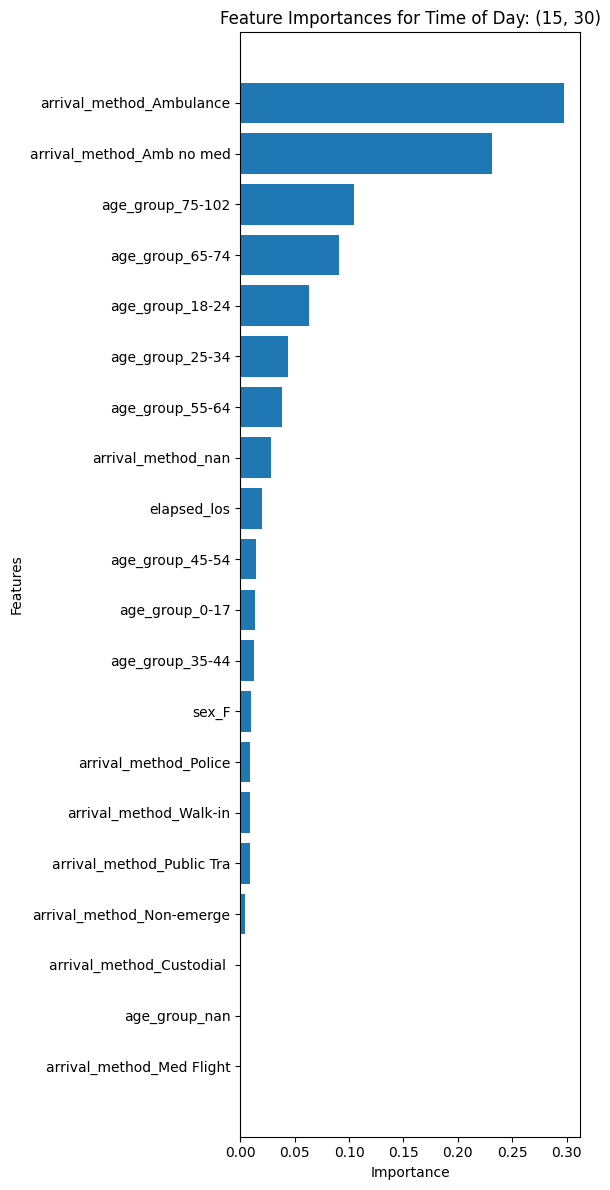

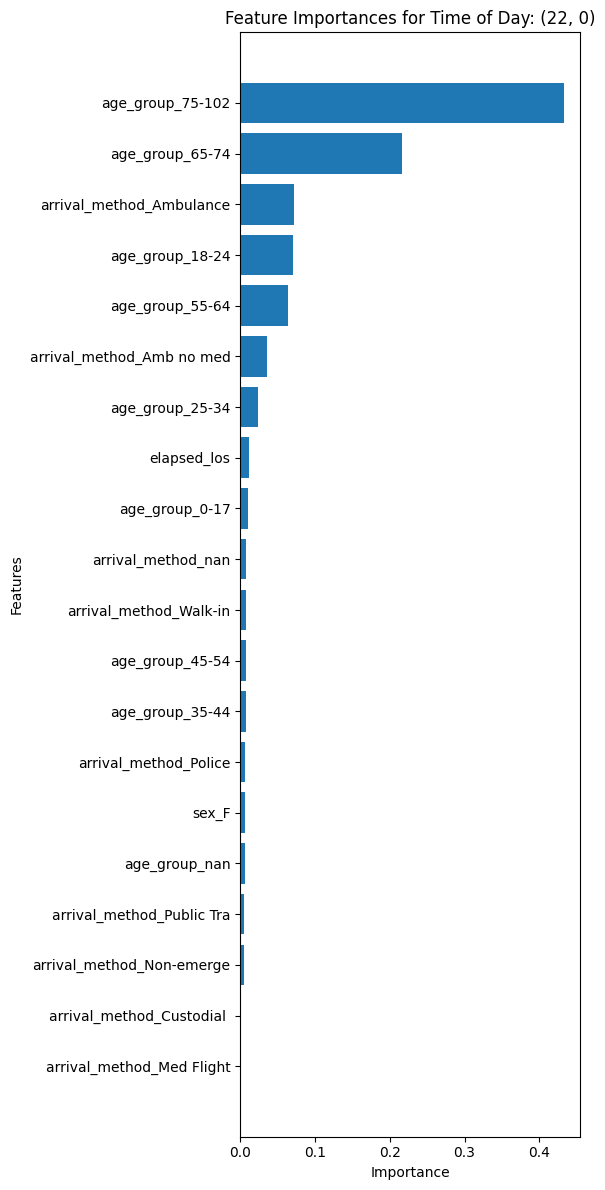

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importances_individually(prediction_times):
    for _prediction_time in prediction_times:
        pipeline = prepare_for_inference(
            model_file_path=model_file_path, 
            model_name='ed_admissions_minimal', 
            prediction_time=_prediction_time, 
            data_path=visits_csv_path, 
            single_snapshot_per_visit=False, 
            model_only=True
        )
        
        transformed_cols = pipeline.named_steps['feature_transformer'].get_feature_names_out()
        transformed_cols = [col.split('__')[-1] for col in transformed_cols]
        truncated_cols = [col[:25] for col in transformed_cols]
        
        feature_importances = pipeline.named_steps['classifier'].feature_importances_
        indices = np.argsort(feature_importances)[-20:]  # Get indices of the top 20 features
        
        plt.figure(figsize=(6, 12))
        plt.title(f"Feature Importances for Time of Day: {_prediction_time}")
        plt.barh(range(len(indices)), feature_importances[indices], align="center")
        plt.yticks(range(len(indices)), np.array(truncated_cols)[indices])
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.tight_layout()

        MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admissions_minimal', _prediction_time)
        feature_plot_path = str(media_file_path / 'feature_plot_') + MODEL__ED_ADMISSIONS__NAME +'.png'
    
        plt.savefig(feature_plot_path)
        plt.show()

plot_feature_importances_individually(prediction_times)